In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

pd.set_option("display.max_columns", 50)

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Get the data

In [2]:
%run get_data.py
benchmarks = ('adpcm_encoder', 'average', 'fir')
gd = GetData('data/ES', benchmarks, load_fpga_v5=False)
gd.main()
gd.data_v4.keys()

dict_keys(['adpcm_encoder', 'average', 'fir'])

# Data analysis

In [191]:
%run methods.py

## Direct Mapping

adpcm_encoder


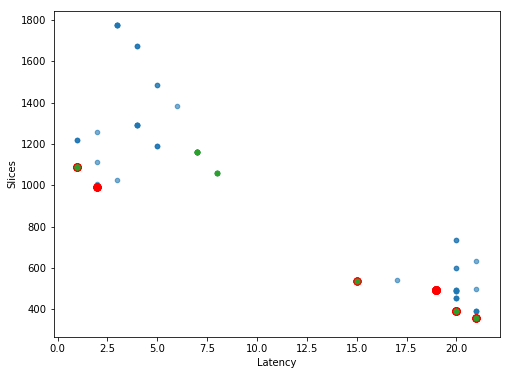

The accurate Pareto set
[[  15  536]
 [  19  493]
 [   2  992]
 [  21  356]
 [  20  392]
 [   1 1089]]
The predicted Pareto set
[[  15  536]
 [  21  356]
 [  20  392]
 [   7 1160]
 [   1 1089]
 [   8 1060]]
adrs_ave: 0.02506897283531409
adrs_max: 0.09778225806451613
adrs_ave_rms: 0.026057874556347293
adrs_max_rms: 0.08753267684958413
hypervolume: 0.27220855398845356
dominance: 0.6666666666666666
cardinality: 6
average


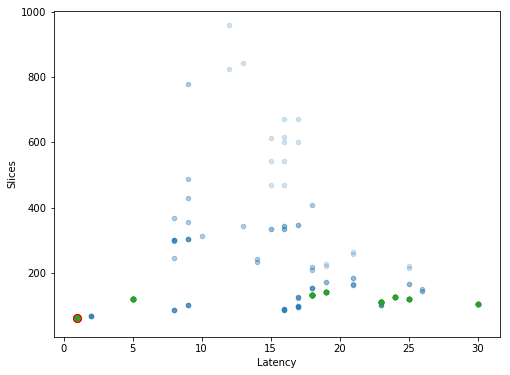

The accurate Pareto set
[[ 1 60]]
The predicted Pareto set
[[ 18 131]
 [ 24 125]
 [ 25 120]
 [ 30 104]
 [ 19 140]
 [ 23 111]
 [  1  60]
 [  5 119]]
adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 0.4526181511763195
dominance: 1.0
cardinality: 8
fir


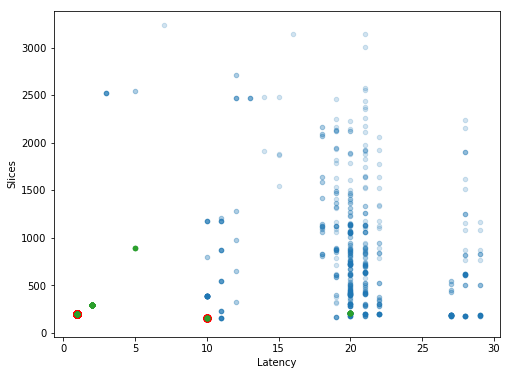

The accurate Pareto set
[[ 10 153]
 [  1 199]]
The predicted Pareto set
[[  1 199]
 [  2 296]
 [ 10 153]
 [  5 891]
 [ 20 206]]
adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 0.3377235497291035
dominance: 1.0
cardinality: 5


In [4]:
results_direct_mapping = {}
for i in benchmarks:
    print(i)
    results_direct_mapping[i] = DirectMapping.main(gd.data_v4[i], plot_figure=True, display_table=True)
    print_results(results_direct_mapping[i])
    print('=' * 40)

## Hands-On ML Chapter 2

In [187]:
%run machine_learning.py

In [10]:
features = ['AREA', 'state', 'FU', 'REG', 'MUX', 'DEC', 'pin_pair',
            'net', 'max', 'min', 'ave', 'MISC', 'MEM', 'sim', 'Pmax',
            'Pmin', 'Pave', 'Latency', 'BlockMemoryBit', 'DSP', 'Slices']
# 'CP_delay',

invalid_features = ['Slices', 'Latency']
valid_features = [i for i in features if i not in invalid_features]
label = 'Slices'

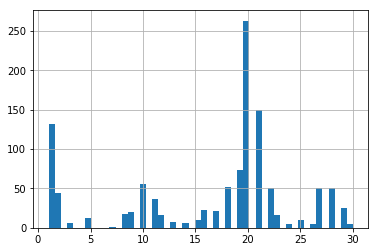

In [172]:
benchmark_training = ['average', 'fir']
data_train = pd.concat([gd.data_v4[i] for i in benchmark_training], ignore_index=True)
# data_train = gd.data_v4[benchmark_training]
data_train['Latency'].hist(bins=50)
plt.show()

In [173]:
# fix missing data
data_train = data_train[features]
data_train = ML.fix_missing_data(data_train)
display(data_train.head(2))
data_train.info()

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,16,0,0,87
1,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,16,0,0,87


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 21 columns):
AREA              1162 non-null int64
state             1162 non-null int64
FU                1162 non-null int64
REG               1162 non-null int64
MUX               1162 non-null int64
DEC               1162 non-null int64
pin_pair          1162 non-null int64
net               1162 non-null int64
max               1162 non-null int64
min               1162 non-null int64
ave               1162 non-null float64
MISC              1162 non-null int64
MEM               1162 non-null int64
sim               1162 non-null int64
Pmax              1162 non-null int64
Pmin              1162 non-null int64
Pave              1162 non-null int64
Latency           1162 non-null int64
BlockMemoryBit    1162 non-null int64
DSP               1162 non-null int64
Slices            1162 non-null int64
dtypes: float64(1), int64(20)
memory usage: 190.7 KB


In [174]:
# X, y
X, y = ML.separate_feature_label(data_train, invalid_features=invalid_features, label=label)
display(X.head(2))
display(y.head(2))

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
0,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,0,0
1,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,0,0


0    87
1    87
Name: Slices, dtype: int64

In [175]:
# feature scaling
X = ML.feature_scaling(X)
print(X.shape)
X

(1162, 19)


array([[-1.0321, -0.7312, -0.8028, ...,  0.    ,  0.    ,  0.    ],
       [-1.0321, -0.7312, -0.8028, ...,  0.    ,  0.    ,  0.    ],
       [-1.0321, -0.7312, -0.8028, ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [-0.1607, -0.5084, -0.5823, ...,  0.    ,  0.    ,  0.    ],
       [-0.1607, -0.5084, -0.5823, ...,  0.    ,  0.    ,  0.    ],
       [-0.1607, -0.5084, -0.5823, ...,  0.    ,  0.    ,  0.    ]])

In [176]:
# feature importance
estimator = RandomForestRegressor()
estimator.fit(X, y)
valid_features = [i for i in features if i not in ['Slices', 'Latency']]
for i in np.argsort(estimator.feature_importances_)[::-1]:
    print('{}: {:7.3}'.format(valid_features[i], estimator.feature_importances_[i]))

MUX:   0.957
pin_pair:  0.0193
net: 0.00643
FU: 0.00615
AREA: 0.00282
REG: 0.00195
state: 0.00192
MISC: 0.00174
ave: 0.00125
min: 0.000931
max: 0.000687
DEC: 0.00017
BlockMemoryBit:     0.0
MEM:     0.0
sim:     0.0
Pmax:     0.0
Pmin:     0.0
Pave:     0.0
DSP:     0.0


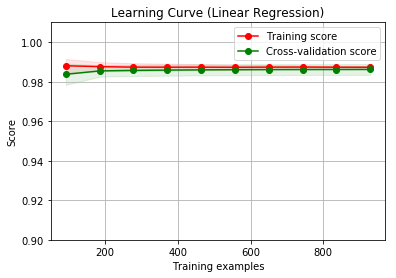

Wall time: 4.1 s


In [177]:
%%time
title = 'Learning Curve (Linear Regression)'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearRegression()
scores = ML.plot_learning_curve(estimator, title, X, y, ylim=(0.9, 1.01), cv=cv, n_jobs=4)
plt.show()

In [178]:
scores

array([[  92.    ,    0.988 ,    0.9837],
       [ 185.    ,    0.9876,    0.9854],
       [ 278.    ,    0.9873,    0.9857],
       [ 371.    ,    0.9873,    0.9859],
       [ 464.    ,    0.9873,    0.986 ],
       [ 557.    ,    0.9873,    0.986 ],
       [ 650.    ,    0.9873,    0.9861],
       [ 743.    ,    0.9874,    0.9861],
       [ 836.    ,    0.9873,    0.9861],
       [ 929.    ,    0.9873,    0.9862]])

In [180]:
train_set, test_set = ML.split_data(data_train, distribution=data_train['Latency'], train_size=278)
train_set.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
838,13838,5,10749,1170,1885,0,23609,10790,5,5,5.0,34,0,0,0,0,0,29,0,0,1163
1153,9784,4,5898,1536,2345,0,17799,7672,4,4,4.0,5,0,0,0,0,0,12,0,0,1279


In [181]:
X, y = ML.separate_feature_label(train_set, invalid_features=['Slices', 'Latency'], label='Slices')
print(X.shape)
X.head(2)

(278, 19)


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
838,13838,5,10749,1170,1885,0,23609,10790,5,5,5.0,34,0,0,0,0,0,0,0
1153,9784,4,5898,1536,2345,0,17799,7672,4,4,4.0,5,0,0,0,0,0,0,0


In [182]:
X = ML.feature_scaling(X)

In [183]:
estimator.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
0,1839,3,670,642,501,0,3588,1621,3,3,3.0,26,0,0,0,0,0,0,0
1,2035,2,900,624,489,0,3905,1793,2,2,2.0,22,0,0,0,0,0,0,0


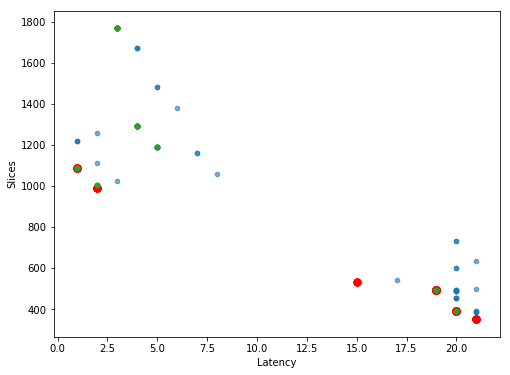

adrs_ave: 0.06365052756634852
adrs_max: 0.26666666666666666
adrs_ave_rms: 0.032606438515916464
adrs_max_rms: 0.10098705326967583
hypervolume: 0.42279252761402464
dominance: 0.5
cardinality: 7

adrs_ave: 0.02506897283531409
adrs_max: 0.09778225806451613
adrs_ave_rms: 0.026057874556347293
adrs_max_rms: 0.08753267684958413
hypervolume: 0.27220855398845356
dominance: 0.6666666666666666
cardinality: 6


In [184]:
data_test = gd.data_v4['adpcm_encoder'][features].replace(regex=[r'-', r'0'], value=0)
X_test, y_test = ML.separate_feature_label(data_test, valid_features=valid_features, label=label)
display(X_test.head(2))
X_test = ML.feature_scaling(X_test)
y_pred = estimator.predict(X_test)
data_test['AREA'] = y_pred
print_results(DirectMapping.main(data_test, plot_figure=True))
print()
print_results(results_direct_mapping['adpcm_encoder'])

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
0,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,0,0
1,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,0,0,0,0,0,0


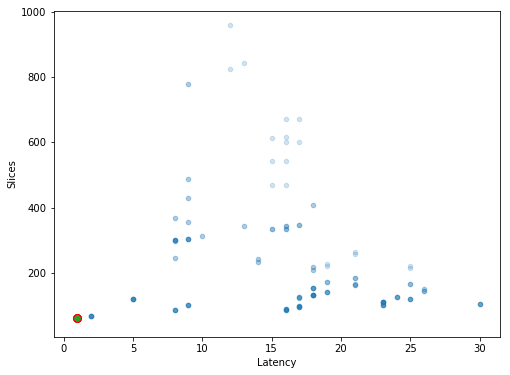

adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 1.0
dominance: 1.0
cardinality: 1

adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 0.4526181511763195
dominance: 1.0
cardinality: 8


In [185]:
data_test = gd.data_v4['average'][features].replace(regex=[r'-', r'0'], value=0)
X_test, y_test = ML.separate_feature_label(data_test, valid_features=valid_features, label=label)
display(X_test.head(2))
X_test = ML.feature_scaling(X_test)
y_pred = estimator.predict(X_test)
data_test['AREA'] = y_pred
print_results(DirectMapping.main(data_test, plot_figure=True))
print()
print_results(results_direct_mapping['average'])

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
0,4704,3,1207,2772,698,0,6834,3256,3,3,3.0,27,0,0,0,0,0,0,0
1,4704,3,1207,2772,698,0,6834,3256,3,3,3.0,27,0,0,0,0,0,0,0


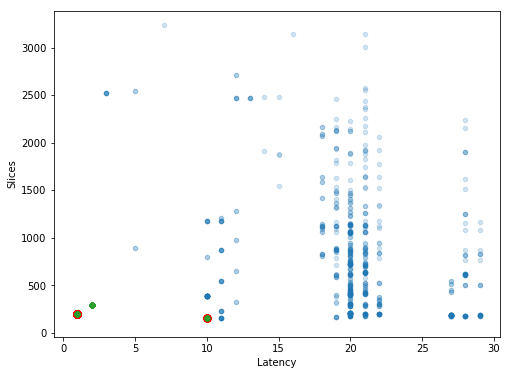

adrs_ave       : 0.0
adrs_max       : 0.0
adrs_ave_rms   : 0.0
adrs_max_rms   : 0.0
hypervolume    : 0.6736627966799287
dominance      : 1.0
cardinality    : 3

adrs_ave       : 0.0
adrs_max       : 0.0
adrs_ave_rms   : 0.0
adrs_max_rms   : 0.0
hypervolume    : 0.3377235497291035
dominance      : 1.0
cardinality    : 5


In [192]:
data_test = gd.data_v4['fir'][features].replace(regex=[r'-', r'0'], value=0)
X_test, y_test = ML.separate_feature_label(data_test, valid_features=valid_features, label=label)
display(X_test.head(2))
X_test = ML.feature_scaling(X_test)
y_pred = estimator.predict(X_test)
data_test['AREA'] = y_pred
print_results(DirectMapping.main(data_test, plot_figure=True))
print()
print_results(results_direct_mapping['fir'])